#**Unsupervised Learning: PCA and k-means clustering**

In this tutorial we will go over two applications of unsupervised learning Principal Component Analysis and K-Means Clustering.

Unsupervised learning is a type of machine learning that learns from data without human supervision. Results from unsupervised learning usually require interpretation ex-post.

Let's import our usual libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

And load our csv

In [4]:
csvFilePath = 'https://raw.githubusercontent.com/robgen/HEDSpython/refs/heads/main/files/WVS_Cross-National_Wave_7_csv_v4_0.csv'
rawData = pd.read_csv(csvFilePath)

<ipython-input-4-9734c227e164>:2: DtypeWarning: Columns (519,520,521,522) have mixed types. Specify dtype option on import or set low_memory=False.
  rawData = pd.read_csv(csvFilePath)


In [5]:
 rawData

,version,doi,A_WAVE,A_YEAR,A_STUDY,B_COUNTRY,B_COUNTRY_ALPHA,C_COW_NUM,C_COW_ALPHA,D_INTERVIEW,...,WVS_Polmistrust_PartyVoter,WVS_LR_MedianVoter,WVS_LibCon_MedianVoter,v2psbars,v2psorgs,v2psprbrch,v2psprlnks,v2psplats,v2xnp_client,v2xps_party
0,4-0-0 (2022-05-23),doi.org/10.14281/18241.18,7,2019,2,196,CYP,352,CYP,196070011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4-0-0 (2022-05-23),doi.org/10.14281/18241.18,7,2019,2,196,CYP,352,CYP,196070036,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4-0-0 (2022-05-23),doi.org/10.14281/18241.18,7,2019,2,196,CYP,352,CYP,196070039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4-0-0 (2022-05-23),doi.org/10.14281/18241.18,7,2019,2,196,CYP,352,CYP,196070040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4-0-0 (2022-05-23),doi.org/10.14281/18241.18,7,2019,2,196,CYP,352,CYP,196070053,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63362,4-0-0 (2022-05-23),doi.org/10.14281/18241.18,7,2019,2,446,MAC,446,MAU,446070582,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63363,4-0-0 (2022-05-23),doi.org/10.14281/18241.18,7,2019,2,446,MAC,446,MAU,446070636,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63364,4-0-0 (2022-05-23),doi.org/10.14281/18241.18,7,2019,2,446,MAC,446,MAU,446070665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63365,4-0-0 (2022-05-23),doi.org/10.14281/18241.18,7,2019,2,446,MAC,446,MAU,446070675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's check what the initial shape of our dataframe is.

In [6]:
print('the initial shape of the dataset is:', rawData.shape)

the initial shape of the dataset is: (63367, 552)


 Now let's take a look at the column names.

In [7]:
print(rawData.columns.tolist())

['version', 'doi', 'A_WAVE', 'A_YEAR', 'A_STUDY', 'B_COUNTRY', 'B_COUNTRY_ALPHA', 'C_COW_NUM', 'C_COW_ALPHA', 'D_INTERVIEW', 'J_INTDATE', 'FW_START', 'FW_END', 'K_TIME_START', 'K_TIME_END', 'K_DURATION', 'Q_MODE', 'N_REGION_ISO', 'N_REGION_WVS', 'N_TOWN', 'G_TOWNSIZE', 'G_TOWNSIZE2', 'H_SETTLEMENT', 'H_URBRURAL', 'I_PSU', 'O1_LONGITUDE', 'O2_LATITUDE', 'L_INTERVIEWER_NUMBER', 'S_INTLANGUAGE', 'LNGE_ISO', 'E_RESPINT', 'F_INTPRIVACY', 'E1_LITERACY', 'W_WEIGHT', 'S018', 'PWGHT', 'S025', 'S007', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q33_3', 'Q34', 'Q34_3', 'Q35', 'Q35_3', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40', 'Q41', 'Q42', 'Q43', 'Q44', 'Q45', 'Q46', 'Q47', 'Q48', 'Q49', 'Q50', 'Q51', 'Q52', 'Q53', 'Q54', 'Q55', 'Q56', 'Q57', 'Q58', 'Q59', 'Q60', 'Q61', 'Q62', 'Q63', 'Q64', 'Q65', 'Q66', 'Q67', 'Q68', 'Q69', 'Q

To select the features which we need in our analysis we take a look at the *WVS questionnaire.pdf* file in th GitHub repository *files* folder to identify the relevant questions.

In this case, we are interested in the 290 questions of the main survey. We know these are registered as *Q* + *question number* so we proceed to subset the dataframe to contain only the questions.

In [8]:
Nquestions = 290
featuresToKeep = []
for q in range(1,Nquestions+1):
    featuresToKeep.append('Q'+str(q))

WVS = rawData.loc[:, featuresToKeep]

print('the final shape of the dataset is:', WVS.shape)

the final shape of the dataset is: (63367, 290)


In [9]:
WVS

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q281,Q282,Q283,Q284,Q285,Q286,Q287,Q288,Q289,Q290
0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,...,6.0,0.0,9.0,1.0,1.0,2.0,3.0,5.0,3.0,196001.0
1,1.0,3.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,1.0,...,8.0,8.0,10.0,2.0,2.0,2.0,4.0,5.0,3.0,196001.0
2,1.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,2.0,...,0.0,6.0,6.0,NaN,2.0,2.0,3.0,3.0,3.0,196001.0
3,1.0,2.0,1.0,4.0,1.0,1.0,1.0,2.0,1.0,1.0,...,8.0,6.0,9.0,2.0,2.0,2.0,3.0,5.0,3.0,196001.0
4,1.0,NaN,2.0,4.0,1.0,1.0,1.0,2.0,1.0,1.0,...,8.0,NaN,9.0,2.0,2.0,2.0,5.0,3.0,3.0,196001.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63362,1.0,2.0,3.0,3.0,2.0,4.0,1.0,1.0,1.0,1.0,...,0.0,11.0,10.0,1.0,2.0,1.0,2.0,6.0,0.0,446006.0
63363,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,8.0,11.0,7.0,1.0,2.0,2.0,4.0,5.0,8.0,446006.0
63364,1.0,2.0,1.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,...,11.0,11.0,11.0,2.0,2.0,2.0,3.0,4.0,7.0,446006.0
63365,2.0,3.0,2.0,4.0,2.0,3.0,1.0,2.0,1.0,2.0,...,4.0,4.0,11.0,2.0,2.0,1.0,2.0,6.0,7.0,446006.0


We also want to retain some general features for later.

In [10]:
generalFeatures = ['B_COUNTRY_ALPHA', 'O1_LONGITUDE', 'O2_LATITUDE']
WVSgeneral = rawData.loc[:, generalFeatures]

We can now delete the del `rawData` from the local memory (as we won't need it anymore and it takes up quite a lot of memory!).

In [11]:
del rawData

To get familiar with the data, let's plot a histogram of the observations by country.

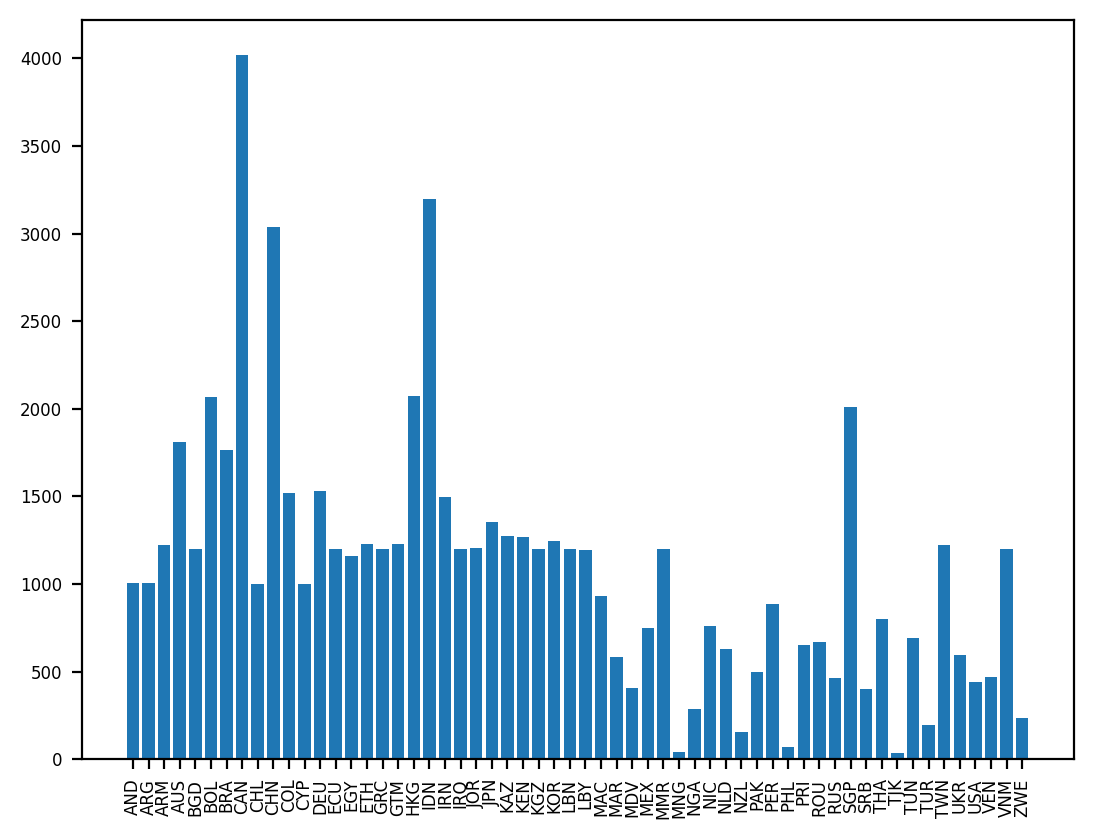

In [12]:
countries, numSurveysInCountry = np.unique(WVSgeneral.B_COUNTRY_ALPHA,return_counts=True)
dummy = range(len(countries))

plt.figure(dpi=200)
plt.rcParams.update({'font.size': 6})
plt.bar(dummy,numSurveysInCountry, align='center')
plt.xticks(dummy, countries)
plt.xticks(rotation = 90)
plt.show()

Now let's clean the dataset. For each question we want to check which is the most common value and how many null values there are.

In [13]:
nanQuestions = []
weirdQuestions =[]
for q in range(1,Nquestions+1):
    labels, counts = np.unique(WVS['Q'+str(q)],return_counts=True)
    print('Q'+str(q)+' - ', 'Most common: ' , labels[counts.argmax()], ',',
            '#Empty: ', WVS['Q'+str(q)].isna().sum())
    if np.isnan(labels[counts.argmax()]):
        nanQuestions.append('Q' + str(q)) # append questions for which the most common value is nan
    if labels[counts.argmax()] > 10 or labels[counts.argmax()] < 0:
        weirdQuestions.append('Q'+str(q)) # append questions for which the most common value is above 10 or below 0

Q1 -  Most common:  1.0 , #Empty:  77
Q2 -  Most common:  2.0 , #Empty:  197
Q3 -  Most common:  2.0 , #Empty:  335
Q4 -  Most common:  3.0 , #Empty:  746
Q5 -  Most common:  1.0 , #Empty:  621
Q6 -  Most common:  1.0 , #Empty:  517
Q7 -  Most common:  1.0 , #Empty:  232
Q8 -  Most common:  2.0 , #Empty:  809
Q9 -  Most common:  1.0 , #Empty:  513
Q10 -  Most common:  1.0 , #Empty:  391
Q11 -  Most common:  2.0 , #Empty:  880
Q12 -  Most common:  1.0 , #Empty:  445
Q13 -  Most common:  2.0 , #Empty:  866
Q14 -  Most common:  2.0 , #Empty:  864
Q15 -  Most common:  2.0 , #Empty:  837
Q16 -  Most common:  2.0 , #Empty:  803
Q17 -  Most common:  2.0 , #Empty:  874
Q18 -  Most common:  1.0 , #Empty:  573
Q19 -  Most common:  2.0 , #Empty:  735
Q20 -  Most common:  2.0 , #Empty:  877
Q21 -  Most common:  2.0 , #Empty:  786
Q22 -  Most common:  2.0 , #Empty:  2322
Q23 -  Most common:  2.0 , #Empty:  759
Q24 -  Most common:  1.0 , #Empty:  632
Q25 -  Most common:  2.0 , #Empty:  1916
Q26 -  M

In [14]:
nanQuestions

['Q86', 'Q92', 'Q223', 'Q240', 'Q267', 'Q268', 'Q276', 'Q280', 'Q282', 'Q290']

In [15]:
weirdQuestions

['Q261', 'Q262', 'Q266', 'Q272']

We can use the questionnaire pdf in the files folder to check weird values. Q261 is the year of birth, Q262 is age so it is likely these values are above 10 (i.e., they do not look weird), while Q266 and Q272 are respecively out of 2 and 5 in the pdf, so they should not take values above 10 (i.e., they look weird). We re-define weird values accordingly.

In [16]:
weirdQuestions = ['Q266', 'Q272']

We can then delete questions for which most common values are null or weird.

In [17]:
questionsToRemove = nanQuestions + weirdQuestions
WVS = WVS.drop(questionsToRemove, axis=1)

And then substitute `NaN` values with the most frequent answer for each question (the mode). PCA cannot be applied to a dataset with null values.

In [18]:
for name, values in WVS.items():
    labels, counts = np.unique(values,return_counts=True)
    values[values.isna()] = labels[counts.argmax()]

##**Principal Component Analysis**

We use the `sklearn` library to run our analysis. `sklearn` (or scikit-learn) is a powerful library for machine learning.

In [84]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Principal component analysis (PCA) is a dimensionality reduction technique that allows us to reduce a large set fo variables into a smaller one (called principal components) that still contains most of the information of the large dataset.

As a first step we need to standardize all variables in the dataset to make sure that each of the variables contribute equally in the analysis.
Standardizing a variable means to reduce it to a unit scale (that is to mean = 0 and variance = 1).

In [20]:
standWVS = StandardScaler().fit_transform(WVS)

We use the `PCA()` and `.fit_transform()` functions to preform the reduction into a lower dimensional space, the argument `n_components` indicates how many components the variables should be reduced to.

To start with, let's reduce the variables to two principal components.

In [21]:
pcaObj = PCA(n_components=2)
prComp = pcaObj.fit_transform(standWVS)

Let's take a look at the two components.

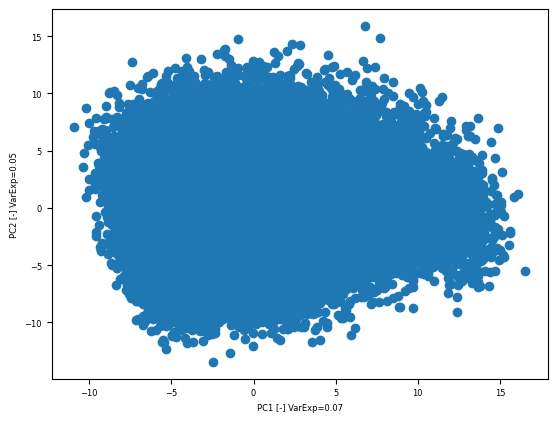

In [22]:
plt.figure(dpi=100)
plt.scatter(prComp[:,0], prComp[:,1])
plt.xlabel('PC1 [-] VarExp=%1.2f' %pcaObj.explained_variance_ratio_[0])
plt.ylabel('PC2 [-] VarExp=%1.2f' %pcaObj.explained_variance_ratio_[1])
plt.show()

PC1 explains the variation on the x-axis while PC2 explains the variation on the y-axis. From this plot we can see already that PC1 explains more variance in the original dataset than PC2 as the scatter is more spread along the x-axis than the y-axis.

Let's now take a look at the loadings for each component.

In [23]:
df_pca = pd.DataFrame(pcaObj.components_.T, columns=['PC1', 'PC2'])
print(df_pca)

          PC1       PC2
0    0.029344  0.029094
1   -0.034412  0.027188
2   -0.031460 -0.017052
3   -0.037248  0.047080
4    0.067268  0.001408
..        ...       ...
273 -0.014304 -0.000066
274 -0.051260  0.028822
275 -0.052342  0.005641
276  0.041681 -0.006181
277 -0.083287 -0.044105

[278 rows x 2 columns]


We can use the largest and smallest loadings to interpret our components.

In [24]:
print(df_pca['PC1'].nlargest(2))
print(df_pca['PC1'].nsmallest(2))

179    0.155307
183    0.154365
Name: PC1, dtype: float64
161   -0.148063
215   -0.130207
Name: PC1, dtype: float64


**PC1 interpretation**

At the *higher end* of the spectrum sit respondents that declared that 'Stealing property' (Q179) and 'Prostitution' (Q183) can be morally justified, that completely disagree with the statement 'One of the bad effects of science is that it breaks down people’s ideas of right and wrong' (Q161) and that have done the action 'Encouraging others to take action about political issues' (Q215).

While at *lower end* of the spectrum stand people who do not morally justify 'Stealing property' (Q179) and 'Prostitution' (Q183), that agree that 'One of the bad effects of science is that it breaks down people’s ideas of right and wrong' (Q161) and that would never 'encourage others to take action about political issues' (Q215).

What would you say is this PC measuring? Take a guess, there is no right or wrong answer.


In [ ]:
print(df_pca['PC2'].nlargest(2))
print(df_pca['PC2'].nsmallest(2))

70    0.186427
72    0.180054
Name: PC2, dtype: float64
247   -0.129224
246   -0.109942
Name: PC2, dtype: float64


**PC2 interpretation**

At the *higher end* of the spectrum are people who do not have a lot of confidence in 'the court' (Q70) and in 'political parties' (Q72) and that think that 'The state makes people’s incomes equal' (Q247) and 'Civil rights protect people from state oppression' (Q246) are not essential characteristics of democracy.

To the contrary, people with *lower scores* of PC2 will have a lot of confidence in 'the court' (Q70) and in 'political parties' (Q72) and will think that 'The state makes people’s incomes equal' (Q247) and 'Civil rights protect people from state oppression' (Q246) are more essential characteristics of democracy.

How do you interpret this PC?

The rule of thumb for PCA is that to have a good summary of the data the cumulative explained variance needs to exceed 70-80% of the variance.

Let's check how much variance is explained by PC1 and PC2.

In [25]:
pcaObj.explained_variance_ratio_.cumsum()

array([0.06893325, 0.12123726])

Only 12%! Not a lot. Let's try with three components then.

In [26]:
pcaObj = PCA(n_components=3)
prComp = pcaObj.fit_transform(standWVS)

In [27]:
pcaObj.explained_variance_ratio_.cumsum()

array([0.06893325, 0.12123726, 0.15557296])

Three PCs explain only 16% of the variance, that's not a lot either. We can still plot this to see what adding a third dimension looks like.

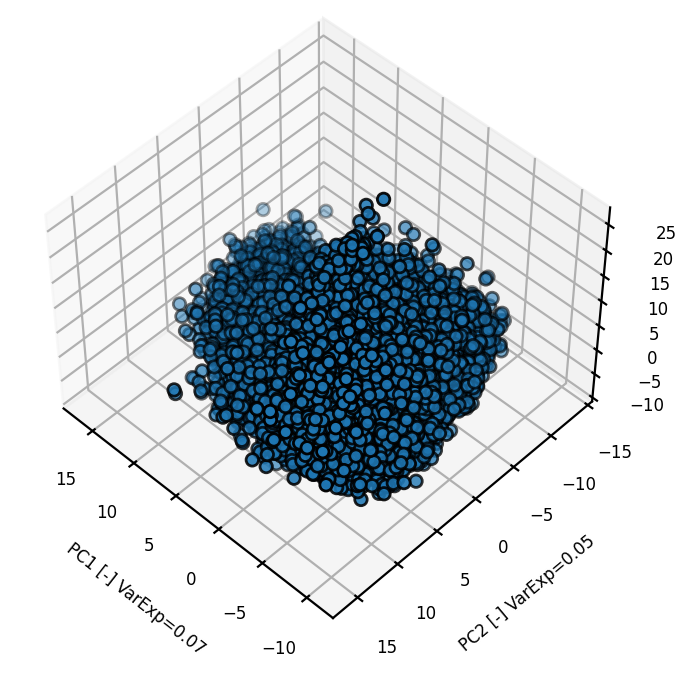

In [28]:
fig = plt.figure(1, figsize=(4, 3), dpi=200)
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
ax.set_position([0, 0, 0.95, 1])
plt.cla()
ax.scatter(prComp[:,0], prComp[:,1], prComp[:,2], edgecolor="k")
ax.set_xlabel('PC1 [-] VarExp=%1.2f' %pcaObj.explained_variance_ratio_[0])
ax.set_ylabel('PC2 [-] VarExp=%1.2f' %pcaObj.explained_variance_ratio_[1])
ax.set_zlabel('PC3 [-] VarExp=%1.2f' %pcaObj.explained_variance_ratio_[2])
plt.show()

To see how many PCs we should reduce our sample to, let's calculate the percentage of variance explained by PCs from 2 up to 139 (half of our sample) - this is called sensitivity analysis.

In [61]:
pcaObjDummy = PCA(n_components=139)
pcDummy = pcaObjDummy.fit_transform(standWVS)
VarianceExplained = pcaObjDummy.explained_variance_
totVarianceExplained = pcaObjDummy.explained_variance_ratio_.cumsum()

And now let's check how 139 PCs do.

In [63]:
totVarianceExplained

0.21456425386795608

Another way to pick the number of components is by using the *elbow method*.
That is, we plot the number of PCs over the total variance and look for an *elbow* (the place where the explained variation begins to slow) in the plot to indicate how many PCs is appropriate to use.

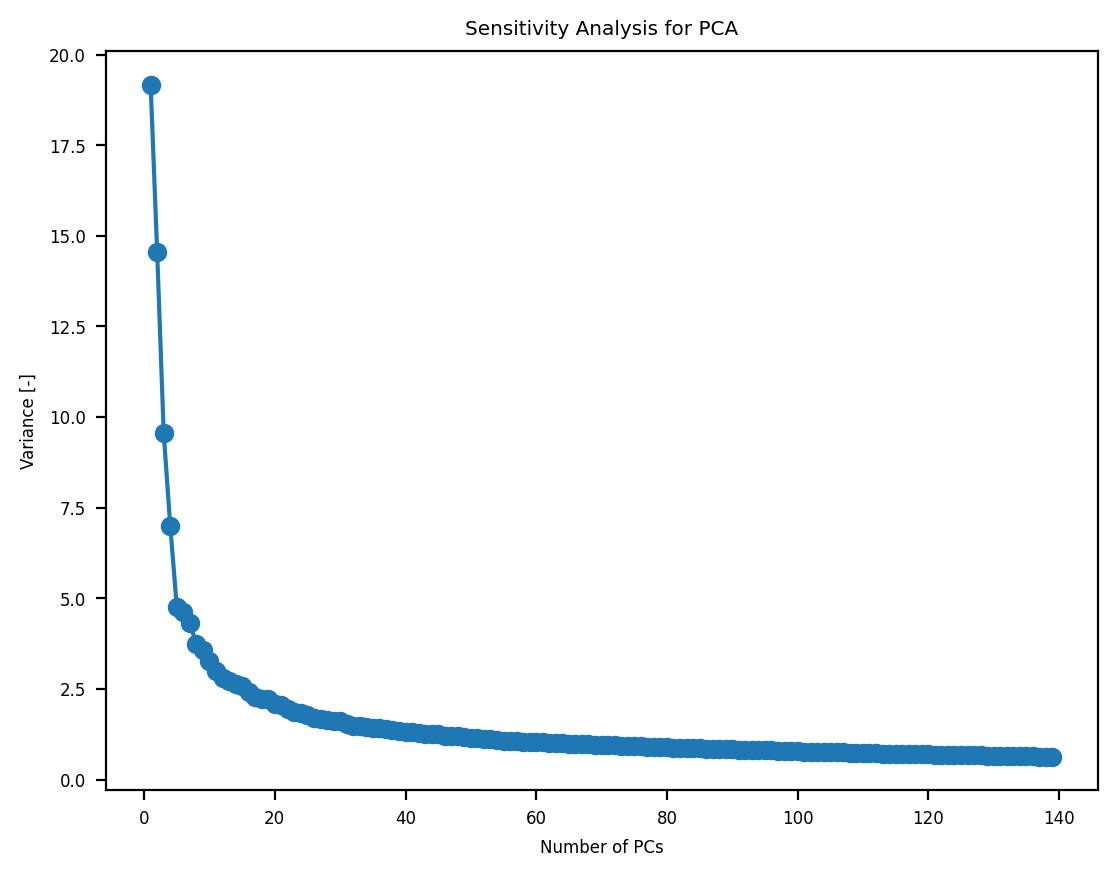

In [47]:
plt.figure(dpi=200)
plt.plot(range(1, 140), VarianceExplained, marker='o')
plt.title('Sensitivity Analysis for PCA')
plt.xlabel('Number of PCs')
plt.ylabel('Variance [-]')
plt.show()

We can see a *elbow* around the 5th component indicating a decrease in the explained variation. Let's take a look more closely.

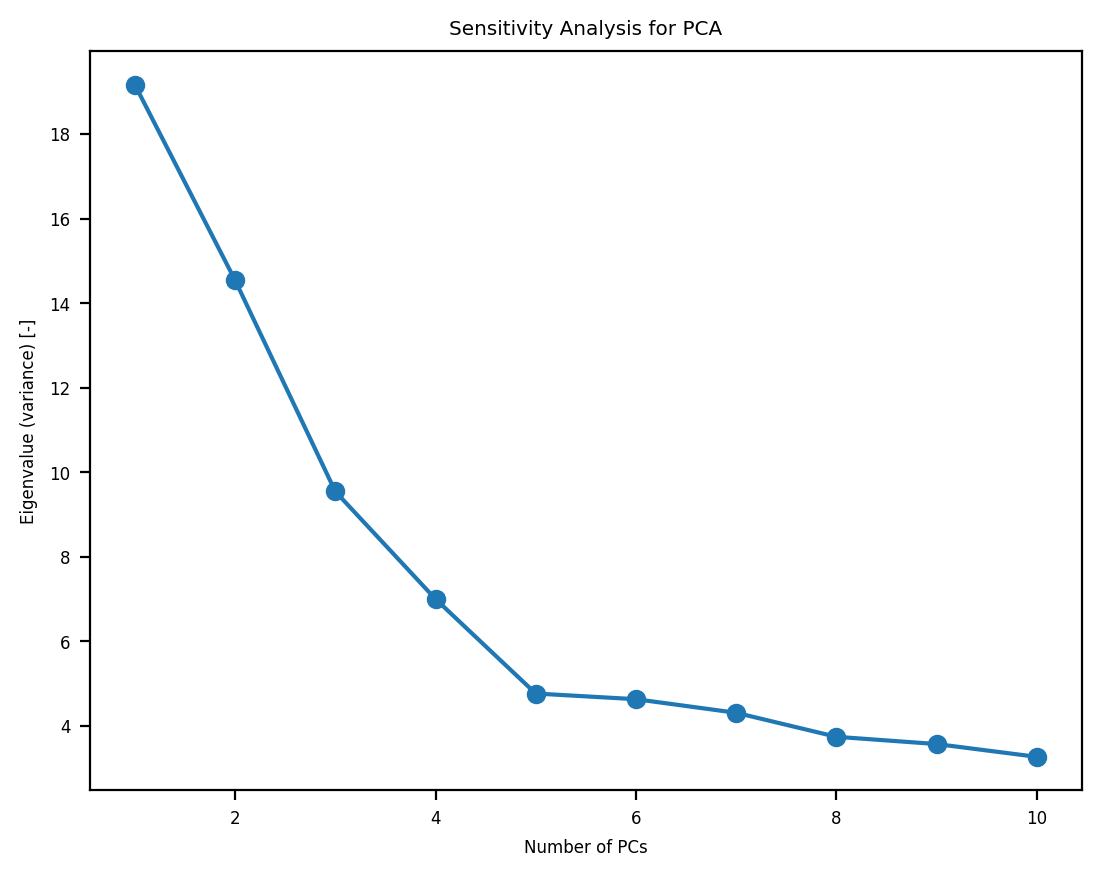

In [58]:
plt.figure(dpi=200)
plt.plot(range(1, 11), VarianceExplained[:10], marker='o')
plt.title('Sensitivity Analysis for PCA')
plt.xlabel('Number of PCs')
plt.ylabel('Eigenvalue (variance) [-]')
plt.show()

In [68]:
totVarianceExplained[5]

0.21456425386795608

There is clearly a elbow in our plot. Yet, total variance explained by PC5 is only around 20%. Let's see how many components we may need to hit the 70-80% mark.

In [70]:
totVarianceExplained[-1]

0.7810842678346029

139 components explain 78% of the variance. That's a lot of components but still we managed to reduce our dataframe by half the features (278 initially), not bad right?!

## **K-means clustering**

K-means clustering allows us to divide our dataset into a defined number of clusters (k) by assigning each observation to the cluster with the nearest mean.

We combine k-means clustering with PCA to increase the data segmentation of our results. PCA reduced the number of features to fewer uncorrelated ones, reducing the noise in the data which can now be grouped more easily.

To simplify the computation, we reduce our dataframe to two components in our application.

Similarly to PCA, perform k-means clustering in `sklearn` we use a combination of the functions `KMeans()` and `fit()`.

In [72]:
inertias = []
Nclusters = range(1,10)
for i in Nclusters:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(prComp)
    inertias.append(kmeans.inertia_)

Similarly to PCA we can use *elbow method* to determine how many clusters we should keep. That is, we look for the *elbow* or the place where the inertia begins to slow.

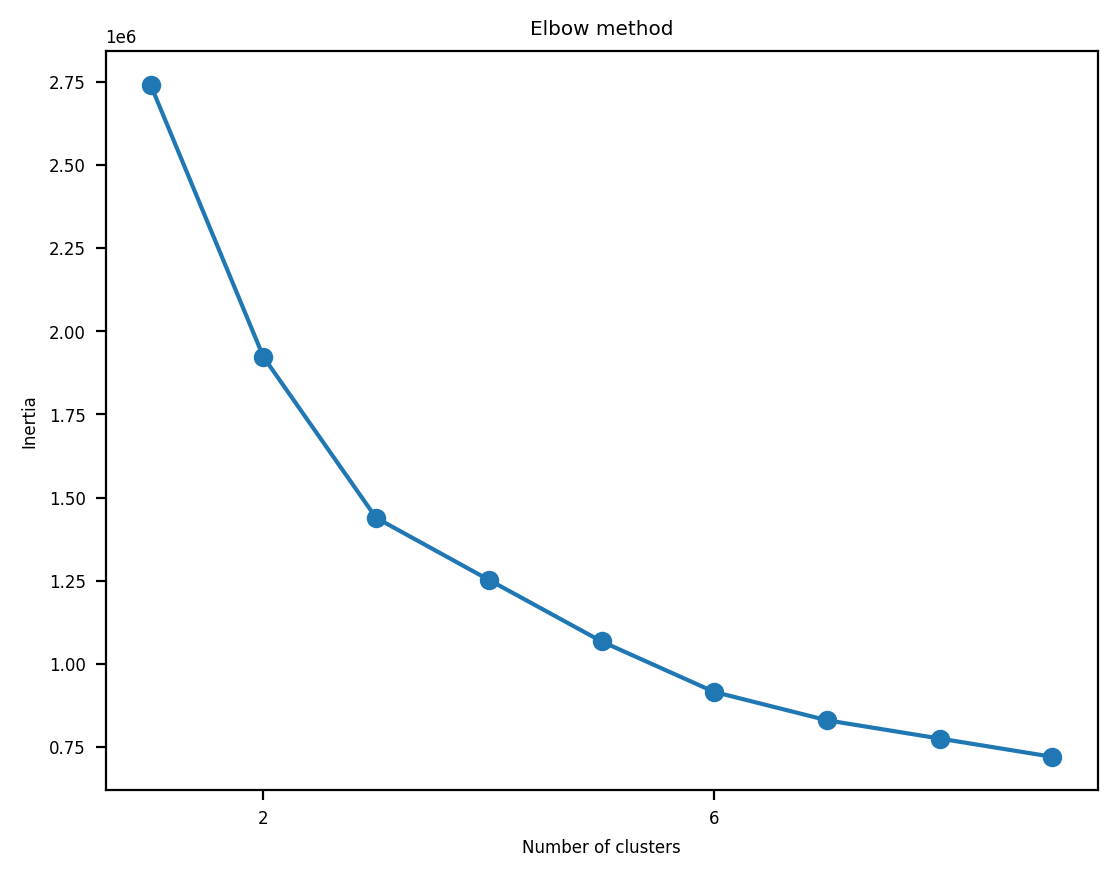

In [73]:
plt.figure(dpi=200)
plt.plot(Nclusters, inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.xticks(Nclusters[1::4])
plt.ylabel('Inertia')
plt.show()

In this case, 3 seems the right number of clusters to use.

Let's now combine the two methods and take a look at our clusters.

In [95]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(prComp)

KMeans(n_clusters=3)

We define the clusters centroids representing the average of each cluster.

In [96]:
centroids = kmeans.cluster_centers_
print("Cluster Centroids:\n", centroids)

Cluster Centroids:
 [[-2.20662632 -3.35690225  0.11672919]
 [ 5.53334045 -0.05833485 -0.26058565]
 [-2.18017548  3.48426171  0.08955426]]


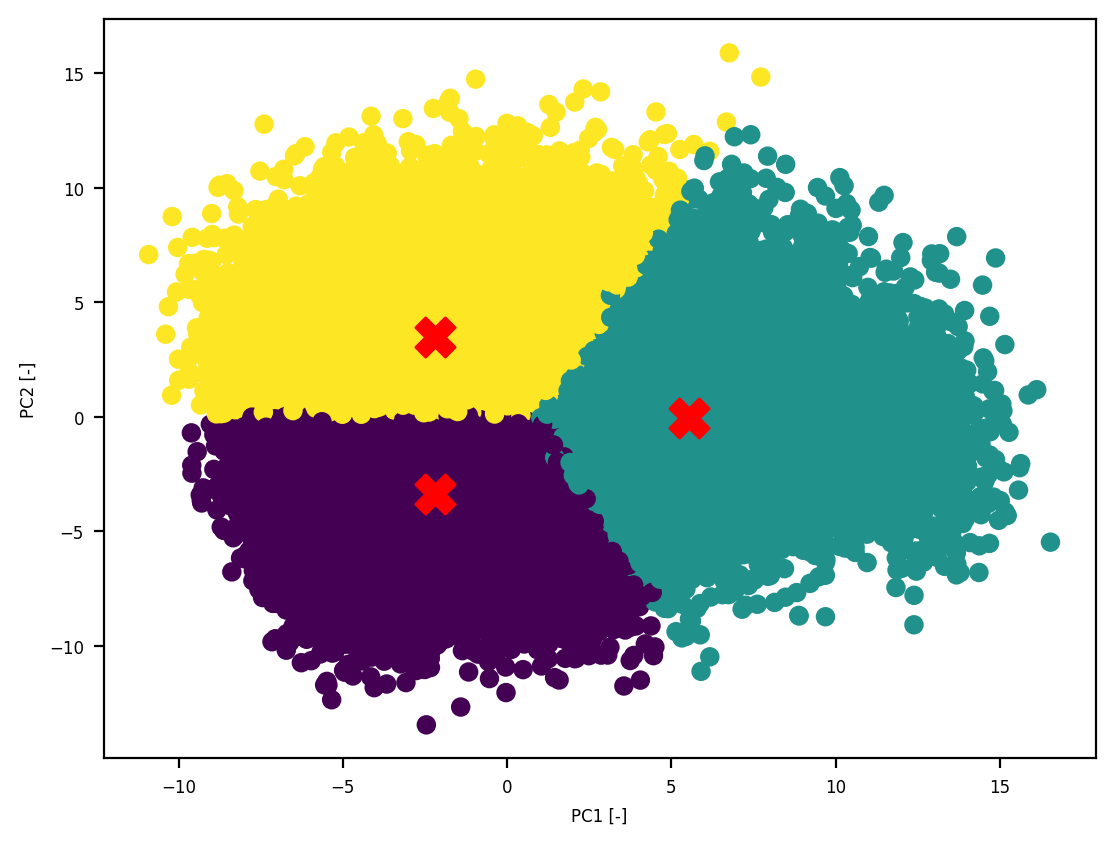

In [97]:
plt.figure(dpi=200)
plt.scatter(prComp[:,0], prComp[:,1], c= kmeans.labels_)
plt.scatter(centroids[:, 0], centroids[:, 1], marker="X", s=200, color="red", label="Centroids")
plt.xlabel('PC1 [-]')
plt.ylabel('PC2 [-]')
plt.show()

Our clusters are somehow separated (i.e., minimal overal is present) and centroids are apart from each other and located at the center of each cluster.

Another way to check if clustering is successful is to compute its Silhouette score, measuring how well a point fits within its assigned cluster.

* Silhouette Score = 1: Well-clustered (tight clusters, good separation)
* Silhouette Score = 0: Overlapping clusters (unclear boundary)
* Silhouette Score = -1: Wrong clustering (point assigned to the wrong group)

In [98]:
sil_score = silhouette_score(prComp, kmeans.labels_)
sil_score

0.28523553828533366

As expected, our score shows some overlap as the value is closer to 0 than to 1.